## Week 8 notebook

For this week, include ideas such as K-Nearest Neighbors and distance metrics. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.neighbors import KNeighborsClassifier

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report, precision_score, recall_score

random_state = 0

In [2]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
# Create a function to load and split data
def split_data(df: pd.DataFrame, target=None, test_size=0.2, random_state=random_state, choice='norm'):

    # Feature and target
    X = df.drop(columns=target)
    y = df[target]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    # reshaye y to 1D array
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Normalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

In [4]:
# Load the cleaned datasets
df_ins = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv')
df_car = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv')

In [5]:
# Encode the datasets
df_ins_encoded = encoding(df_ins, one_hot=False)
df_ins_oh = encoding(df_ins, one_hot=True)

df_car_encoded = encoding(df_car, one_hot=False)
df_car_oh = encoding(df_car, one_hot=True)

In [6]:
# Regularized data
X_train_car_reg, X_test_car_reg, y_train_car_reg, y_test_car_reg, df_car_reg = split_data(df_car_encoded, target='FraudFound', choice='reg')
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = split_data(df_ins_encoded, target='fraud_reported', choice='reg')

# Regularized One-hot data
X_train_car_oh_reg, X_test_car_oh_reg, y_train_car_oh_reg, y_test_car_oh_reg, df_car_oh_reg = split_data(df_car_oh, target='FraudFound', choice='reg')
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = split_data(df_ins_oh, target='fraud_reported', choice='reg')

In [7]:
# Dictionary to store gridsearch results
grid_params = {}

In [8]:
def gridsearchcv(model, X_train, y_train, param_dict=None, title=None, random_state=random_state, scoring='recall', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    # Store results in global dictionary
    global grid_params
    grid_params[title] = {
        'best_params': grid_best_params,
        'best_cv_score': grid_cv_score,
        'results_df': renamed_results
    }

    return grid_best_params, grid_cv_score

In [9]:
def classifier_model(model_class, X_train, y_train, X_test, y_test, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
        results: Dictionary of results for later analysis.
    """
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {clf_name}:")
    print(classification_report(y_test, y_pred, output_dict=False))
    print("\n")

    # Calculate accuracy, f1, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    print(f"{clf_name} F1 score: {f1:.2f}")
    print(f"{clf_name} Precision: {precision:.2f}")
    print(f"{clf_name} Recall: {recall:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.tight_layout()
    plt.show()

    # Save results for later analysis
    results = {
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

    return model, y_pred, results

## Insurance Claims Dataset

In [11]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_reg_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_ins_reg, grid_cv_score_ins_reg = gridsearchcv(KNeighborsClassifier,
                                                               X_train_ins_reg,
                                                               y_train_ins_reg,
                                                               param_dict=ins_reg_param_grid,
                                                               title="Insurance KNN Classification with regularized features",
                                                               random_state=random_state,
                                                               scoring='recall',
                                                               cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            1  1  uniform       0.283205      0.077955               1.0              0.0
     auto            1  1 distance       0.283205      0.077955               1.0              0.0
     auto            2  1 distance       0.283205      0.077955               1.0              0.0
ball_tree            1  1 distance       0.283205      0.077955               1.0              0.0
ball_tree            1  1  uniform       0.283205      0.077955               1.0              0.0

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.2832


In [12]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_oh_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_ins_oh, grid_cv_score_ins_oh = gridsearchcv(KNeighborsClassifier,
                                                             X_train_ins_oh_reg,
                                                             y_train_ins_oh_reg,
                                                             param_dict=ins_oh_param_grid,
                                                             title = "Insurance KNN Classification with one-hot encoded regularized features",
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            1  1  uniform       0.252692      0.049085               1.0              0.0
     auto            1  1 distance       0.252692      0.049085               1.0              0.0
     auto            2  1 distance       0.252692      0.049085               1.0              0.0
ball_tree            1  1 distance       0.252692      0.049085               1.0              0.0
ball_tree            1  1  uniform       0.252692      0.049085               1.0              0.0

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.2527


Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       151
           1       0.25      0.08      0.12        49

    accuracy                           0.71       200
   macro avg       0.50      0.50      0.48       200
weighted avg       0.63      0.71      0.66       200



KNeighborsClassifier Accuracy: 0.71
KNeighborsClassifier F1 score: 0.66
KNeighborsClassifier Precision: 0.63
KNeighborsClassifier Recall: 0.71


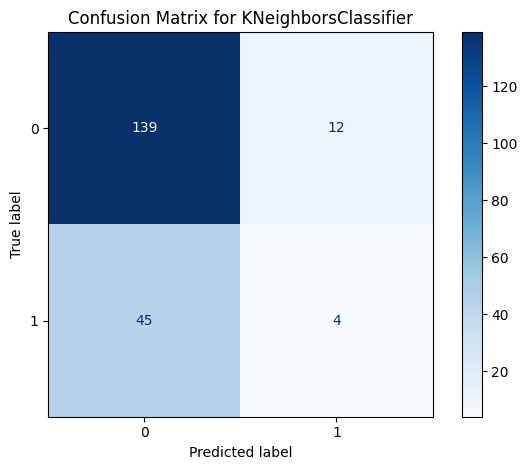

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       151
           1       0.32      0.12      0.18        49

    accuracy                           0.72       200
   macro avg       0.54      0.52      0.50       200
weighted avg       0.65      0.72      0.67       200



KNeighborsClassifier Accuracy: 0.72
KNeighborsClassifier F1 score: 0.67
KNeighborsClassifier Precision: 0.65
KNeighborsClassifier Recall: 0.72


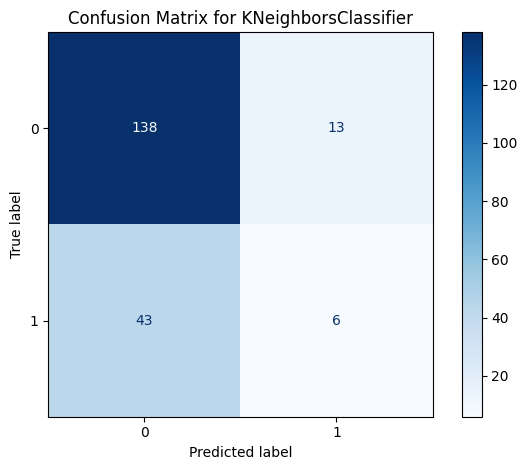

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       151
           1       0.31      0.33      0.32        49

    accuracy                           0.66       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.66      0.66      0.66       200



KNeighborsClassifier Accuracy: 0.66
KNeighborsClassifier F1 score: 0.66
KNeighborsClassifier Precision: 0.66
KNeighborsClassifier Recall: 0.66


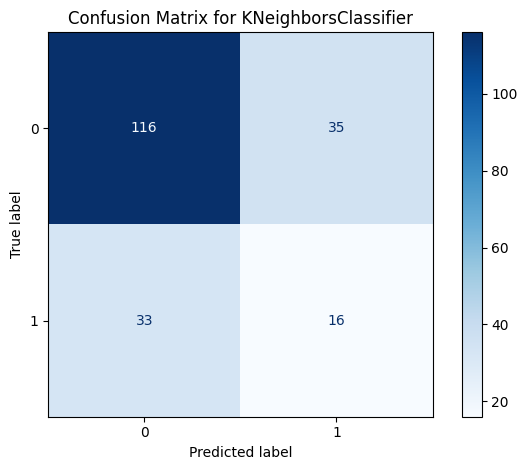

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       151
           1       0.41      0.45      0.43        49

    accuracy                           0.70       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.72      0.70      0.71       200



KNeighborsClassifier Accuracy: 0.70
KNeighborsClassifier F1 score: 0.71
KNeighborsClassifier Precision: 0.72
KNeighborsClassifier Recall: 0.70


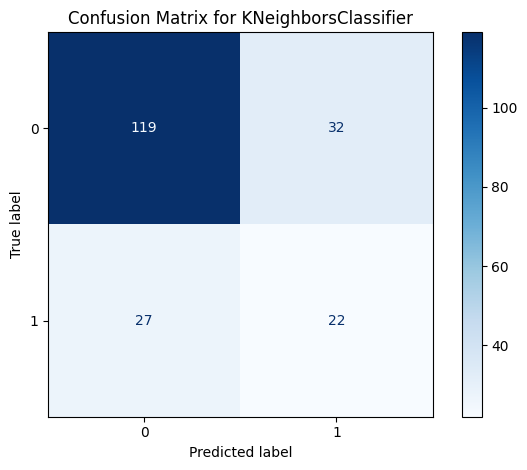

In [14]:
# Run a baseline version of KNN on the insurance claims dataset with one-hot encoding and without
base_ins_reg_model, base_ins_reg_pred, base_ins_reg_results = classifier_model(
    KNeighborsClassifier,
    X_train_ins_reg,
    y_train_ins_reg,
    X_test_ins_reg,
    y_test_ins_reg
)

base_ins_oh_model, base_ins_oh_pred, base_ins_oh_results = classifier_model(
    KNeighborsClassifier, 
    X_train_ins_oh_reg, 
    y_train_ins_oh_reg, 
    X_test_ins_oh_reg, 
    y_test_ins_oh_reg
)

# Run the classifier model bunction with the best parameters from gridsearch
grid_ins_reg_model, grid_ins_reg_pred, grid_ins_reg_results = classifier_model(
    KNeighborsClassifier, 
    X_train_ins_reg, 
    y_train_ins_reg, 
    X_test_ins_reg, 
    y_test_ins_reg, 
    **grid_best_params_ins_reg
)

grid_ins_oh_model, grid_ins_oh_pred, grid_ins_oh_results = classifier_model(
    KNeighborsClassifier,
    X_train_ins_oh_reg,
    y_train_ins_oh_reg,
    X_test_ins_oh_reg,
    y_test_ins_oh_reg,
    **grid_best_params_ins_oh
)

In [15]:
# DataFrame of the Insurance Claims results
df_ins_results = pd.DataFrame({
    'base_oh': base_ins_oh_results,
    'base_en': base_ins_reg_results,
    'grid_oh': grid_ins_oh_results,
    'grid_en': grid_ins_reg_results
})

# Print the results DataFrame
print("\nInsurance Claims Results DataFrame:")
df_ins_results


Insurance Claims Results DataFrame:


,base_oh,base_en,grid_oh,grid_en
model_name,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier
model_params,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
accuracy,0.72,0.715,0.705,0.66
f1_score,0.670886,0.656691,0.709677,0.662267
precision,0.653004,0.631603,0.715192,0.664648
recall,0.72,0.715,0.705,0.66


## Car Claims Dataset

In [16]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
car_oh_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_car_oh, grid_cv_score_car_oh = gridsearchcv(KNeighborsClassifier,
                                                             X_train_car_oh_reg,
                                                             y_train_car_oh_reg,
                                                             param_dict=car_oh_param_grid,
                                                             title = "Car Claims KNN Classification with one-hot encoded regularized features",
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            1  1  uniform       0.138629      0.020778               1.0              0.0
     auto            1  1 distance       0.138629      0.020778               1.0              0.0
     auto            2  1 distance       0.138629      0.020778               1.0              0.0
ball_tree            1  1 distance       0.138629      0.020778               1.0              0.0
ball_tree            1  1  uniform       0.138629      0.020778               1.0              0.0

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.1386


In [17]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
car_reg_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_car_reg, grid_cv_score_car_reg = gridsearchcv(KNeighborsClassifier,
                                                             X_train_car_reg,
                                                             y_train_car_reg,
                                                             param_dict=car_reg_param_grid,
                                                             title = "Car Claims KNN Classification with regularized features",
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            1  1  uniform       0.187679      0.015607               1.0              0.0
     auto            1  1 distance       0.187679      0.015607               1.0              0.0
     auto            2  1 distance       0.187679      0.015607               1.0              0.0
ball_tree            1  1 distance       0.187679      0.015607               1.0              0.0
ball_tree            1  1  uniform       0.187679      0.015607               1.0              0.0

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.1877


Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2842
           1       0.28      0.04      0.07       178

    accuracy                           0.94      3020
   macro avg       0.61      0.52      0.52      3020
weighted avg       0.90      0.94      0.91      3020



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.91
KNeighborsClassifier Precision: 0.90
KNeighborsClassifier Recall: 0.94


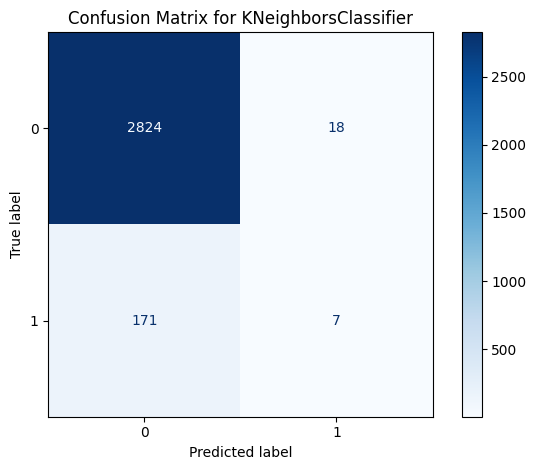

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2842
           1       0.60      0.03      0.06       178

    accuracy                           0.94      3020
   macro avg       0.77      0.52      0.52      3020
weighted avg       0.92      0.94      0.92      3020



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.92
KNeighborsClassifier Precision: 0.92
KNeighborsClassifier Recall: 0.94


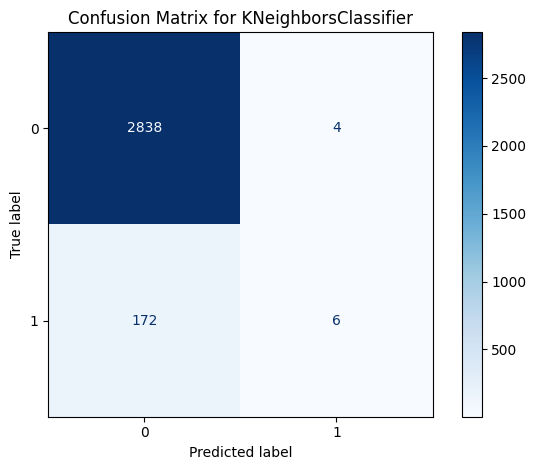

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2842
           1       0.17      0.17      0.17       178

    accuracy                           0.90      3020
   macro avg       0.56      0.56      0.56      3020
weighted avg       0.90      0.90      0.90      3020



KNeighborsClassifier Accuracy: 0.90
KNeighborsClassifier F1 score: 0.90
KNeighborsClassifier Precision: 0.90
KNeighborsClassifier Recall: 0.90


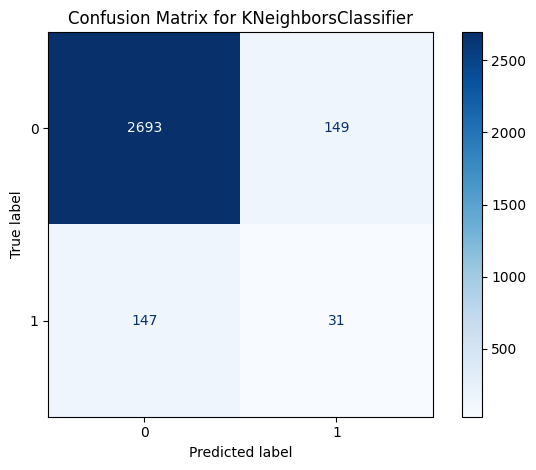

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2842
           1       0.13      0.13      0.13       178

    accuracy                           0.90      3020
   macro avg       0.54      0.54      0.54      3020
weighted avg       0.90      0.90      0.90      3020



KNeighborsClassifier Accuracy: 0.90
KNeighborsClassifier F1 score: 0.90
KNeighborsClassifier Precision: 0.90
KNeighborsClassifier Recall: 0.90


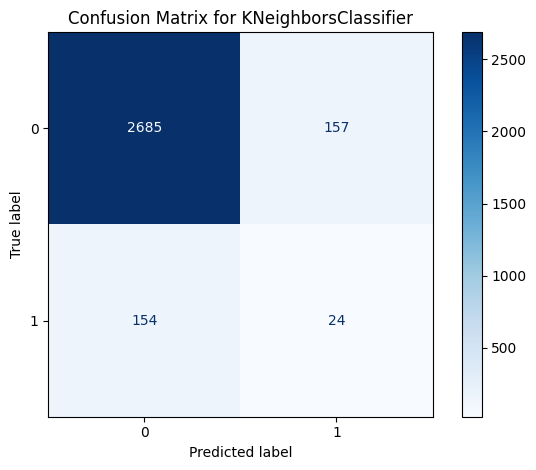

In [18]:
# Run a baseline version of KNN on the insurance claims dataset with one-hot encoding and without
base_car_reg_model, base_car_reg_pred, base_car_reg_results = classifier_model(
    KNeighborsClassifier,
    X_train_car_reg,
    y_train_car_reg,
    X_test_car_reg,
    y_test_car_reg
)

base_car_oh_model, base_car_oh_pred, base_car_oh_results = classifier_model(
    KNeighborsClassifier, 
    X_train_car_oh_reg,
    y_train_car_oh_reg,
    X_test_car_oh_reg,
    y_test_car_oh_reg
)

# Run the classifier model bunction with the best parameters from gridsearch
grid_car_reg_model, grid_car_reg_pred, grid_car_reg_results = classifier_model(
    KNeighborsClassifier, 
    X_train_car_reg, 
    y_train_car_reg, 
    X_test_car_reg, 
    y_test_car_reg, 
    **grid_best_params_car_reg
)

grid_car_oh_model, grid_car_oh_pred, grid_car_oh_results = classifier_model(
    KNeighborsClassifier,
    X_train_car_oh_reg,
    y_train_car_oh_reg,
    X_test_car_oh_reg,
    y_test_car_oh_reg ,
    **grid_best_params_car_oh
)

In [20]:
# DataFrame of the Insurance Claims results
df_car_results = pd.DataFrame({
    'base_oh': base_car_reg_results,
    'base_en': base_car_oh_results,
    'grid_oh': grid_car_reg_results,
    'grid_en': grid_car_oh_results
})

# Print the results DataFrame
print("\nCar Claims Results DataFrame:")
df_car_results


Car Claims Results DataFrame:


,base_oh,base_en,grid_oh,grid_en
model_name,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier
model_params,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
accuracy,0.937417,0.941722,0.901987,0.89702
f1_score,0.914653,0.916519,0.902243,0.897423
precision,0.903833,0.922649,0.902501,0.897828
recall,0.937417,0.941722,0.901987,0.89702


The results of the Car Claims dataset was similar to eariler iterations of classification methods, the class imbalance of the target variable leads the model to predict majority True Negative, aka No Fraud Found. Will continue to experiment with weight balancing parameters for the class imbalance however, it seems to be a major factor in the models being able to predict correctly.